<a href="https://colab.research.google.com/github/ykitaguchi77/AdvancedPytorch_Colab/blob/master/Pytorch_%E8%BB%A2%E7%A7%BB%E5%AD%A6%E7%BF%92MixNet_StawberryApple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PyTorch : Ghostnetを用いたdeep learning（転移学習も）

http://torch.classcat.com/2018/04/29/pytorch-tutorial-transfer-learning/


#自作データ、Early stopping

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

#Advanced Pytorchから
import glob
import os.path as osp
import random
import json
from PIL import Image
from tqdm import tqdm
%matplotlib inline


plt.ion()   # interactive mode

#Google driveのデータをマウント
データの位置
/content/drive/My drive/AI_laboratory_course

In [4]:
'''
フォルダ構成(※class名は4文字にすること)
---dataset.zip-----train-----appl
               |          |--stra
               |
               |---val-------appl
                          |--stra
'''


from google.colab import drive
drive.mount('/content/drive')

#dataset.zipを解凍

!date -R
!unzip -qq drive/My\ Drive/AI_laboratory_course/dataset.zip
!date -R
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Tue, 24 Mar 2020 02:24:15 +0000
Tue, 24 Mar 2020 02:24:25 +0000
drive  sample_data  train  val


#データをロードする
データをロードするために torchvision と torch.utils.data パッケージを使用します。Trainとvalに分けて読み込みます。

In [5]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる

"""
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
"""

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.5,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



print(class_names)
k=0
for i in class_names:
    print(class_names[k]+"_train:"+str(len(os.listdir(path= data_dir + '/train/'+class_names[k]))))
    k+=1
k=0
for i in class_names:
    print(class_names[k]+"_val:"+str(len(os.listdir(path= data_dir + '/val/'+class_names[k]))))
    k+=1

print("training data set_total："+ str(len(image_datasets['train'])))
print("validating data set_total："+str(len(image_datasets['val'])))

['appl', 'stra']
appl_train:252
stra_train:252
appl_val:67
stra_val:60
training data set_total：504
validating data set_total：127


#少数の画像を可視化する

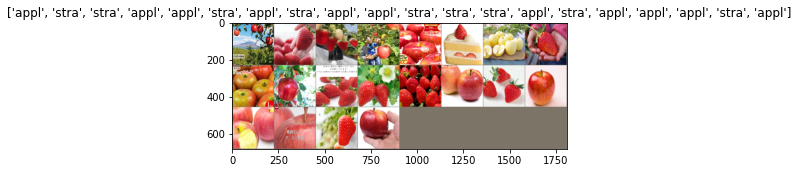

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#Define the Early Stopping Class

In [0]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

#モデルを訓練する
さて、モデルを訓練するための一般的な関数を書きましょう。ここで、次を示します :

学習率をスケジューリングする
ベスト・モデルをセーブする
以下で、パラメータ scheduler は torch.optim.lr_scheduler からの LR scheduler オブジェクトです。

In [0]:
def train_model(model, criterion, optimizer, scheduler, patience, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # to track the training loss as the model trains
    train_loss = []
    # to track the validation loss as the model trains
    valid_loss = []


    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase] 
            
            # record train_loss and valid_loss
            if phase == 'train':
                train_loss.append(epoch_loss)
            if phase == 'val':
                valid_loss.append(epoch_loss)
            #print(train_loss)
            #print(valid_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
      
      # early_stopping needs the validation loss to check if it has decresed, 
      # and if it has, it will make a checkpoint of the current model
        if phase == 'val':    
            early_stopping(epoch_loss, model)
                
            if early_stopping.early_stop:
                print("Early stopping")
                break
        print()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, valid_loss

#モデル予測を可視化する
少数の画像のための予測を表示するための一般的な関数。

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#convnet を再調整する
モデルをロードして最後の完全結合層をリセットします。<br>
※pretrained = False　→事前訓練していない状態になります<br>
※pretrained = True　→事前訓練された状態（強化学習）

In [0]:
"""
Creates a Mixnet Model:
Modified from https://github.com/romulus0914/MixNet-Pytorch/blob/master/mixnet.py
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import math

class Swish(nn.Module):
    def __init__(self):
        super(Swish, self).__init__()

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return x * self.sigmoid(x)

NON_LINEARITY = {
    'ReLU': nn.ReLU(inplace=True),
    'Swish': Swish(),
}

def _RoundChannels(c, divisor=8, min_value=None):
    if min_value is None:
        min_value = divisor
    new_c = max(min_value, int(c + divisor / 2) // divisor * divisor)
    if new_c < 0.9 * c:
        new_c += divisor
    return new_c

def _SplitChannels(channels, num_groups):
    split_channels = [channels//num_groups for _ in range(num_groups)]
    split_channels[0] += channels - sum(split_channels)
    return split_channels

def Conv3x3Bn(in_channels, out_channels, stride, non_linear='ReLU'):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        NON_LINEARITY[non_linear]
    )

def Conv1x1Bn(in_channels, out_channels, non_linear='ReLU'):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
        nn.BatchNorm2d(out_channels),
        NON_LINEARITY[non_linear]
    )

class SqueezeAndExcite(nn.Module):
    def __init__(self, channels, squeeze_channels, se_ratio):
        super(SqueezeAndExcite, self).__init__()

        squeeze_channels = squeeze_channels * se_ratio
        if not squeeze_channels.is_integer():
            raise ValueError('channels must be divisible by 1/ratio')

        squeeze_channels = int(squeeze_channels)
        self.se_reduce = nn.Conv2d(channels, squeeze_channels, 1, 1, 0, bias=True)
        self.non_linear1 = NON_LINEARITY['Swish']
        self.se_expand = nn.Conv2d(squeeze_channels, channels, 1, 1, 0, bias=True)
        self.non_linear2 = nn.Sigmoid()

    def forward(self, x):
        y = torch.mean(x, (2, 3), keepdim=True)
        y = self.non_linear1(self.se_reduce(y))
        y = self.non_linear2(self.se_expand(y))
        y = x * y

        return y

class GroupedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(GroupedConv2d, self).__init__()

        self.num_groups = len(kernel_size)
        self.split_in_channels = _SplitChannels(in_channels, self.num_groups)
        self.split_out_channels = _SplitChannels(out_channels, self.num_groups)

        self.grouped_conv = nn.ModuleList()
        for i in range(self.num_groups):
            self.grouped_conv.append(nn.Conv2d(
                self.split_in_channels[i],
                self.split_out_channels[i],
                kernel_size[i],
                stride=stride,
                padding=padding,
                bias=False
            ))

    def forward(self, x):
        if self.num_groups == 1:
            return self.grouped_conv[0](x)

        x_split = torch.split(x, self.split_in_channels, dim=1)
        x = [conv(t) for conv, t in zip(self.grouped_conv, x_split)]
        x = torch.cat(x, dim=1)

        return x

class MDConv(nn.Module):
    def __init__(self, channels, kernel_size, stride):
        super(MDConv, self).__init__()

        self.num_groups = len(kernel_size)
        self.split_channels = _SplitChannels(channels, self.num_groups)

        self.mixed_depthwise_conv = nn.ModuleList()
        for i in range(self.num_groups):
            self.mixed_depthwise_conv.append(nn.Conv2d(
                self.split_channels[i],
                self.split_channels[i],
                kernel_size[i],
                stride=stride,
                padding=kernel_size[i]//2,
                groups=self.split_channels[i],
                bias=False
            ))

    def forward(self, x):
        if self.num_groups == 1:
            return self.mixed_depthwise_conv[0](x)

        x_split = torch.split(x, self.split_channels, dim=1)
        x = [conv(t) for conv, t in zip(self.mixed_depthwise_conv, x_split)]
        x = torch.cat(x, dim=1)

        return x

class MixNetBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size=[3],
        expand_ksize=[1],
        project_ksize=[1],
        stride=1,
        expand_ratio=1,
        non_linear='ReLU',
        se_ratio=0.0
    ):

        super(MixNetBlock, self).__init__()

        expand = (expand_ratio != 1)
        expand_channels = in_channels * expand_ratio
        se = (se_ratio != 0.0)
        self.residual_connection = (stride == 1 and in_channels == out_channels)

        conv = []

        if expand:
            # expansion phase
            pw_expansion = nn.Sequential(
                GroupedConv2d(in_channels, expand_channels, expand_ksize),
                nn.BatchNorm2d(expand_channels),
                NON_LINEARITY[non_linear]
            )
            conv.append(pw_expansion)

        # depthwise convolution phase
        dw = nn.Sequential(
            MDConv(expand_channels, kernel_size, stride),
            nn.BatchNorm2d(expand_channels),
            NON_LINEARITY[non_linear]
        )
        conv.append(dw)

        if se:
            # squeeze and excite
            squeeze_excite = SqueezeAndExcite(expand_channels, in_channels, se_ratio)
            conv.append(squeeze_excite)

        # projection phase
        pw_projection = nn.Sequential(
            GroupedConv2d(expand_channels, out_channels, project_ksize),
            nn.BatchNorm2d(out_channels)
        )
        conv.append(pw_projection)

        self.conv = nn.Sequential(*conv)

    def forward(self, x):
        if self.residual_connection:
            return x + self.conv(x)
        else:
            return self.conv(x)

class MixNet(nn.Module):
    # [in_channels, out_channels, kernel_size, expand_ksize, project_ksize, stride, expand_ratio, non_linear, se_ratio]
    mixnet_s = [(16,  16,  [3],              [1],    [1],    1, 1, 'ReLU',  0.0),
                (16,  24,  [3],              [1, 1], [1, 1], 2, 6, 'ReLU',  0.0),
                (24,  24,  [3],              [1, 1], [1, 1], 1, 3, 'ReLU',  0.0),
                (24,  40,  [3, 5, 7],        [1],    [1],    2, 6, 'Swish', 0.5),
                (40,  40,  [3, 5],           [1, 1], [1, 1], 1, 6, 'Swish', 0.5),
                (40,  40,  [3, 5],           [1, 1], [1, 1], 1, 6, 'Swish', 0.5),
                (40,  40,  [3, 5],           [1, 1], [1, 1], 1, 6, 'Swish', 0.5),
                (40,  80,  [3, 5, 7],        [1],    [1, 1], 2, 6, 'Swish', 0.25),
                (80,  80,  [3, 5],           [1],    [1, 1], 1, 6, 'Swish', 0.25),
                (80,  80,  [3, 5],           [1],    [1, 1], 1, 6, 'Swish', 0.25),
                (80,  120, [3, 5, 7],        [1, 1], [1, 1], 1, 6, 'Swish', 0.5),
                (120, 120, [3, 5, 7, 9],     [1, 1], [1, 1], 1, 3, 'Swish', 0.5),
                (120, 120, [3, 5, 7, 9],     [1, 1], [1, 1], 1, 3, 'Swish', 0.5),
                (120, 200, [3, 5, 7, 9, 11], [1],    [1],    2, 6, 'Swish', 0.5),
                (200, 200, [3, 5, 7, 9],     [1],    [1, 1], 1, 6, 'Swish', 0.5),
                (200, 200, [3, 5, 7, 9],     [1],    [1, 1], 1, 6, 'Swish', 0.5)]
    
    mixnet_m = [(24,  24,  [3],          [1],    [1],    1, 1, 'ReLU',  0.0),
                (24,  32,  [3, 5, 7],    [1, 1], [1, 1], 2, 6, 'ReLU',  0.0),
                (32,  32,  [3],          [1, 1], [1, 1], 1, 3, 'ReLU',  0.0),
                (32,  40,  [3, 5, 7, 9], [1],    [1],    2, 6, 'Swish', 0.5),
                (40,  40,  [3, 5],       [1, 1], [1, 1], 1, 6, 'Swish', 0.5),
                (40,  40,  [3, 5],       [1, 1], [1, 1], 1, 6, 'Swish', 0.5),
                (40,  40,  [3, 5],       [1, 1], [1, 1], 1, 6, 'Swish', 0.5),
                (40,  80,  [3, 5, 7],    [1],    [1],    2, 6, 'Swish', 0.25),
                (80,  80,  [3, 5, 7, 9], [1, 1], [1, 1], 1, 6, 'Swish', 0.25),
                (80,  80,  [3, 5, 7, 9], [1, 1], [1, 1], 1, 6, 'Swish', 0.25),
                (80,  80,  [3, 5, 7, 9], [1, 1], [1, 1], 1, 6, 'Swish', 0.25),
                (80,  120, [3],          [1],    [1],    1, 6, 'Swish', 0.5),
                (120, 120, [3, 5, 7, 9], [1, 1], [1, 1], 1, 3, 'Swish', 0.5),
                (120, 120, [3, 5, 7, 9], [1, 1], [1, 1], 1, 3, 'Swish', 0.5),
                (120, 120, [3, 5, 7, 9], [1, 1], [1, 1], 1, 3, 'Swish', 0.5),
                (120, 200, [3, 5, 7, 9], [1],    [1], 2, 6, 'Swish', 0.5),
                (200, 200, [3, 5, 7, 9], [1],    [1, 1], 1, 6, 'Swish', 0.5),
                (200, 200, [3, 5, 7, 9], [1],    [1, 1], 1, 6, 'Swish', 0.5),
                (200, 200, [3, 5, 7, 9], [1],    [1, 1], 1, 6, 'Swish', 0.5)]

    def __init__(self, net_type='mixnet_s', input_size=224, num_classes=1000, stem_channels=16, feature_size=1536, depth_multiplier=1.0):
        super(MixNet, self).__init__()

        if net_type == 'mixnet_s':
            config = self.mixnet_s
            stem_channels = 16
            dropout_rate = 0.2
        elif net_type == 'mixnet_m':
            config = self.mixnet_m
            stem_channels = 24
            dropout_rate = 0.25
        elif net_type == 'mixnet_l':
            config = self.mixnet_m
            stem_channels = 24
            depth_multiplier *= 1.3
            dropout_rate = 0.25
        else:
            raise TypeError('Unsupported MixNet type')

        assert input_size % 32 == 0

        # depth multiplier
        if depth_multiplier != 1.0:
            stem_channels = _RoundChannels(stem_channels*depth_multiplier)

            for i, conf in enumerate(config):
                conf_ls = list(conf)
                conf_ls[0] = _RoundChannels(conf_ls[0]*depth_multiplier)
                conf_ls[1] = _RoundChannels(conf_ls[1]*depth_multiplier)
                config[i] = tuple(conf_ls)

        # stem convolution
        self.stem_conv = Conv3x3Bn(3, stem_channels, 2)

        # building MixNet blocks
        layers = []
        for in_channels, out_channels, kernel_size, expand_ksize, project_ksize, stride, expand_ratio, non_linear, se_ratio in config:
            layers.append(MixNetBlock(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                expand_ksize=expand_ksize,
                project_ksize=project_ksize,
                stride=stride,
                expand_ratio=expand_ratio,
                non_linear=non_linear,
                se_ratio=se_ratio
            ))
        self.layers = nn.Sequential(*layers)

        # last several layers
        self.head_conv = Conv1x1Bn(config[-1][1], feature_size)

        self.avgpool = nn.AvgPool2d(input_size//32, stride=1)
        self.classifier = nn.Linear(feature_size, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

        self._initialize_weights()

    def forward(self, x):
        x = self.stem_conv(x)
        x = self.layers(x)
        x = self.head_conv(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        x = self.dropout(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2.0 / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()



class Flatten(nn.Module): 
    """One layer module that flattens its input."""
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

In [18]:
model_ft = MixNet().to(device)

print(model_ft)

#from torchsummary import summary
#summary(model_ft, (3,224,224))


MixNet(
  (stem_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layers): Sequential(
    (0): MixNetBlock(
      (conv): Sequential(
        (0): Sequential(
          (0): MDConv(
            (mixed_depthwise_conv): ModuleList(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            )
          )
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Sequential(
          (0): GroupedConv2d(
            (grouped_conv): ModuleList(
              (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            )
          )
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
  

In [19]:
from torchsummary import summary
summary(model_ft, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
              ReLU-3         [-1, 16, 112, 112]               0
              ReLU-4         [-1, 16, 112, 112]               0
              ReLU-5         [-1, 16, 112, 112]               0
              ReLU-6         [-1, 16, 112, 112]               0
              ReLU-7         [-1, 16, 112, 112]               0
              ReLU-8         [-1, 16, 112, 112]               0
              ReLU-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 16, 112, 112]             144
           MDConv-11         [-1, 16, 112, 112]               0
      BatchNorm2d-12         [-1, 16, 112, 112]              32
             ReLU-13         [-1, 16, 112, 112]               0
             ReLU-14         [-1, 16, 1

In [0]:
model_ft.classifier = nn.Linear(in_features=1536, out_features=2, bias=True)
#print(model_ft)


In [0]:
#GPU使用
model_ft = model_ft.to(device)

#損失関数を定義
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

#訓練と評価
CPU 上でおよそ 15-25 分かかるはずです。けれども GPU 上なら、1 分もかかりません。

In [14]:
model_ft, train_loss, valid_loss = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, patience=5, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.6882 Acc: 0.5556
val Loss: 0.6948 Acc: 0.5276
Validation loss decreased (inf --> 0.694769).  Saving model ...

Epoch 1/24
----------
train Loss: 0.5908 Acc: 0.6905
val Loss: 0.8171 Acc: 0.5276
EarlyStopping counter: 1 out of 5

Epoch 2/24
----------
train Loss: 0.5674 Acc: 0.7202
val Loss: 0.6245 Acc: 0.6535
Validation loss decreased (0.694769 --> 0.624544).  Saving model ...

Epoch 3/24
----------
train Loss: 0.5113 Acc: 0.7560
val Loss: 0.4584 Acc: 0.8110
Validation loss decreased (0.624544 --> 0.458440).  Saving model ...

Epoch 4/24
----------
train Loss: 0.4588 Acc: 0.7976
val Loss: 0.4010 Acc: 0.8583
Validation loss decreased (0.458440 --> 0.401023).  Saving model ...

Epoch 5/24
----------
train Loss: 0.4340 Acc: 0.7956
val Loss: 0.3460 Acc: 0.8819
Validation loss decreased (0.401023 --> 0.345977).  Saving model ...

Epoch 6/24
----------
train Loss: 0.4453 Acc: 0.7817
val Loss: 0.3368 Acc: 0.8661
Validation loss decreased (0.345977 --> 0.336797).  Saving model ...

In [0]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [0]:
visualize_model(model_ft)

#Test datasetにおける正解率を（改めて）計算

In [17]:
correct = 0
total = 0
with torch.no_grad():
    for data in dataloaders['val']:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the test images: 90 %


#ネットワークの保存

In [0]:
PATH = '/content/drive/My Drive/Deep_learning/applstra/applstra.pth'
torch.save(model_ft.state_dict(), PATH)